#Alpha TEAM GO!!!!!!!!

The purpose of the following analysis is to determine if a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes about the cell.

We explored the data using CDFs, scatterplots, and barplots.

Based on the EDA, we decided that a tree based analysis approach was most appropriate to overcome the significant multicollinearity in our data.

Using random forests we deliver a model with 98% accuracy with no false negatives in our test data-set. We further construced a more parsimonoius model of the top 3 predictors which had 97% accuracy and only a single false negative in our test-set.

When all of the measured variables are available we recommend the use of our full model to practitioners to ensure that they can make the best diagnoses possible.

## Loading Data


In [0]:
from google.colab import files
uploaded = files.upload()

Saving breast-cancer-wisconsin.csv to breast-cancer-wisconsin (10).csv


In [0]:
import io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

cols = ["id","Clump Thickness","Uniformity of Cell Size","Uniformity of Cell Shape","Marginal Adhesion",
       "Single Epithelial Cell Size", "Bare Nuclei", "Bland Chromatin","Normal Nucleoli","Mitoses", "class"] #define column names
data = pd.read_csv(io.BytesIO(uploaded['breast-cancer-wisconsin.csv']),names=cols, index_col = False) # read in data


We inspect the data types of each column of our dataframe (all should be non-null and integers)

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id                             699 non-null int64
Clump Thickness                699 non-null int64
Uniformity of Cell Size        699 non-null int64
Uniformity of Cell Shape       699 non-null int64
Marginal Adhesion              699 non-null int64
Single Epithelial Cell Size    699 non-null int64
Bare Nuclei                    699 non-null object
Bland Chromatin                699 non-null int64
Normal Nucleoli                699 non-null int64
Mitoses                        699 non-null int64
class                          699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


Bare-Nuclei does not show up as we would expect, it has the data type "object". Let's take a closer look at this parameter.

In [0]:
data.groupby("Bare Nuclei")["Bare Nuclei"].count()

Bare Nuclei
1     402
10    132
2      30
3      28
4      19
5      30
6       4
7       8
8      21
9       9
?      16
Name: Bare Nuclei, dtype: int64

Looking at the last entry we have 16 observations where Bare Nuclei is a "?", indicating that we have some missing data. Let's see what outcomes these represent.

In [0]:
pd.crosstab(data['Bare Nuclei']=="?", data['class'], margins=True)

class,2,4,All
Bare Nuclei,,,
False,444,239,683
True,14,2,16
All,458,241,699


Here we find out two very valuable pieces of information: first that we have very unbalanced classes and second that most of the "?" appear in our overrepresented class. Therefore we can remove these missing entries from our data

In [0]:
data = data[data['Bare Nuclei'] != "?"]
data['Bare Nuclei'] = pd.to_numeric(data['Bare Nuclei'])

### Example of the Data

In [0]:
data.head()

,id,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


Now we can examine how the features relate to each other.

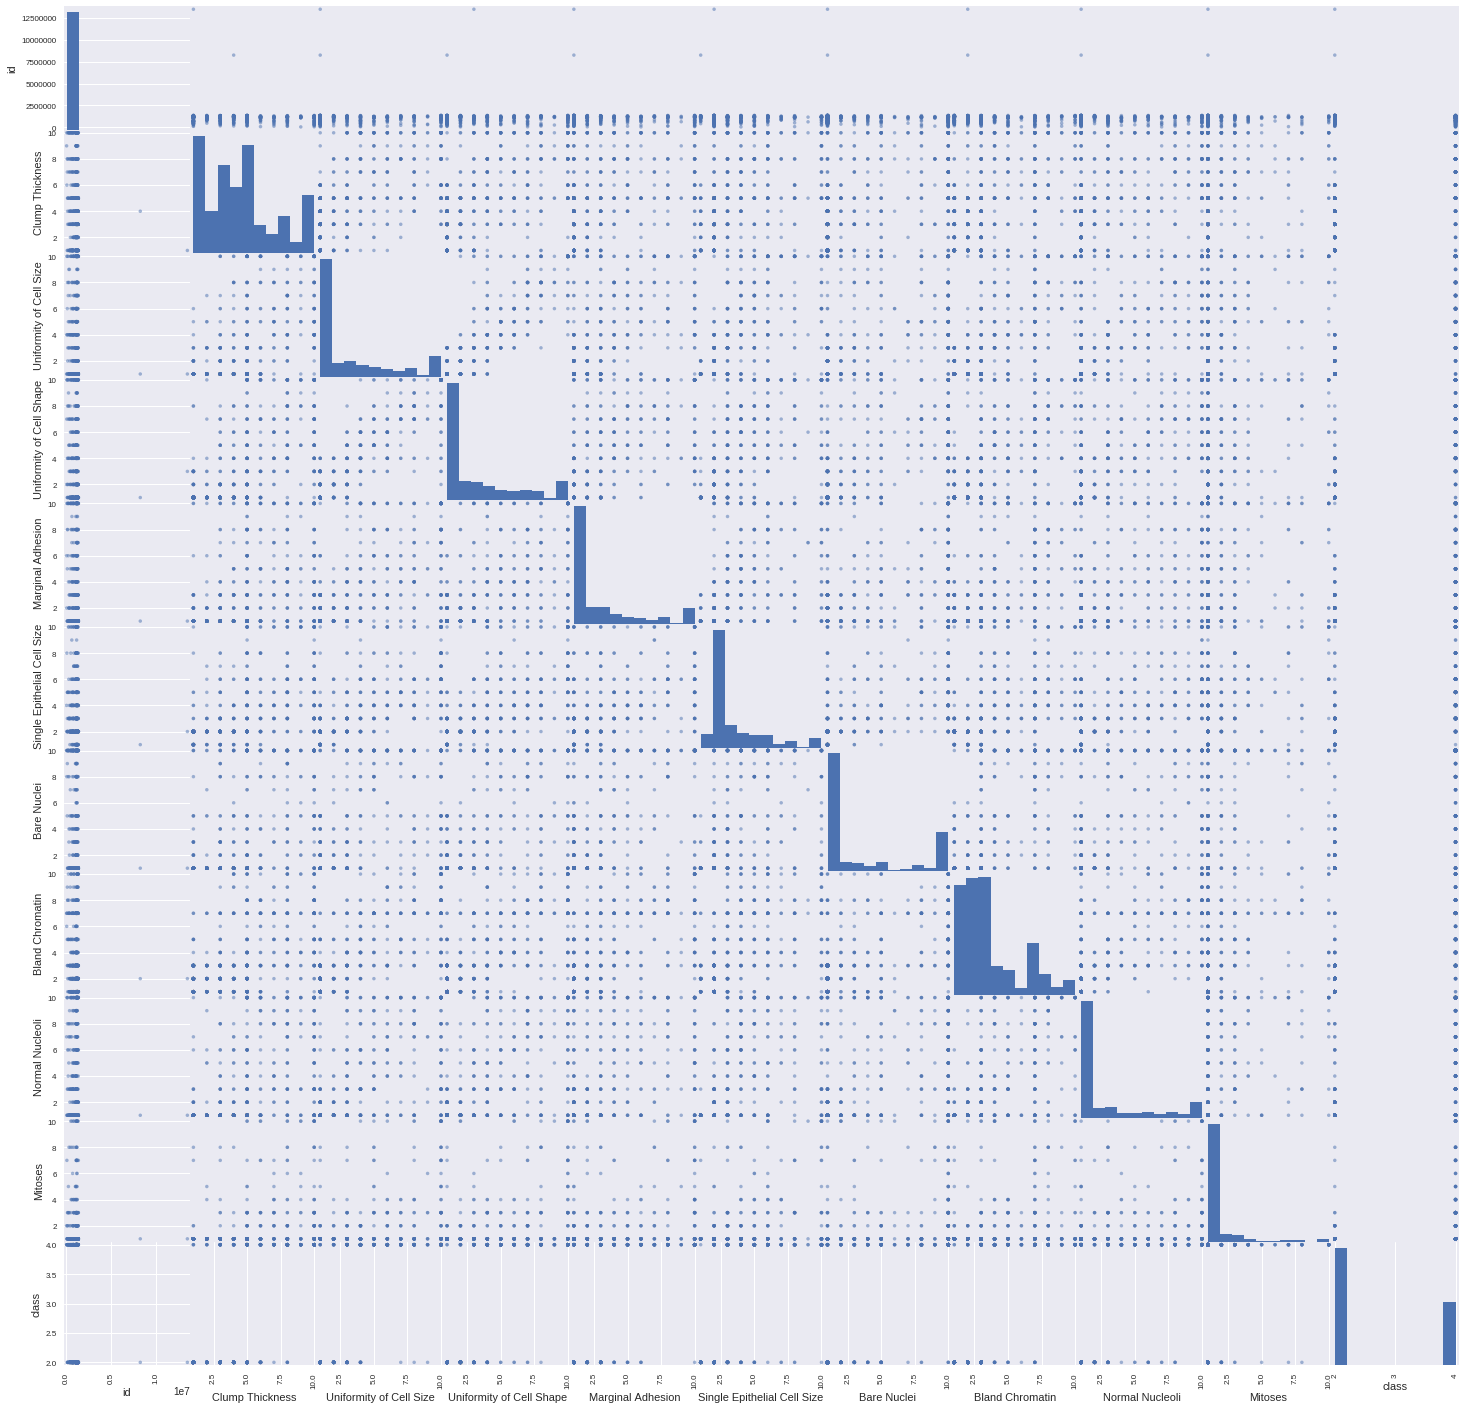

In [0]:
_=pd.plotting.scatter_matrix(data, figsize = (25,25))


Evaluation of the central histograms shows a significant departure from normality for our data.

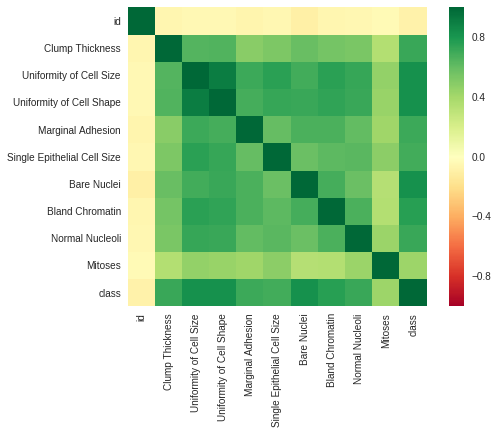

In [0]:
_ = sns.heatmap(data.corr(), square=True, cmap = 'RdYlGn')

Evaluation of the correlations indicates that our data suffers from a large amount of multicollinearity.

Here is the code to oversample the underrepresented class (4=malignant) so that we have balanced outcomes.

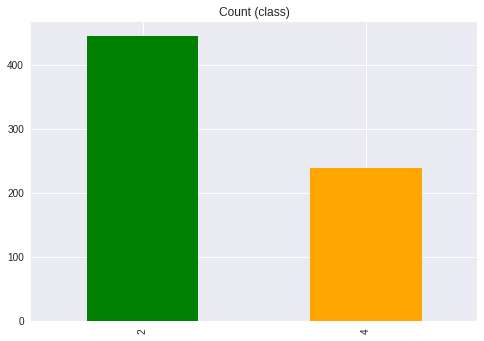

In [0]:
# Class count
count_class_2, count_class_4 = data['class'].value_counts()

# Divide by class
df_class_2 = data[data['class'] == 2]
df_class_4 = data[data['class'] == 4]

# bar plot before resample to see change
data['class'].value_counts().plot(kind='bar', title='Count (class)', color = ['green','orange']);

Random over-sampling:
4    444
2    444
Name: class, dtype: int64


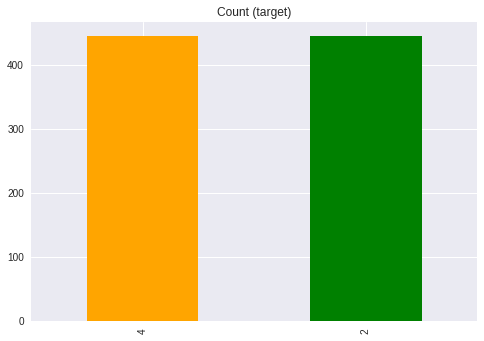

In [0]:
# resample to match the count of class 2
df_class_4_over = df_class_4.sample(count_class_2, replace=True)

# combine to new dataframe
df_resampled = pd.concat([df_class_2, df_class_4_over], axis=0)

print('Random over-sampling:')
print(df_resampled['class'].value_counts())

df_resampled['class'].value_counts().plot(kind='bar', title='Count (target)', color = ['orange','green']);

Below we see that there is markedly more variance in the malignant cells than those which are benign.

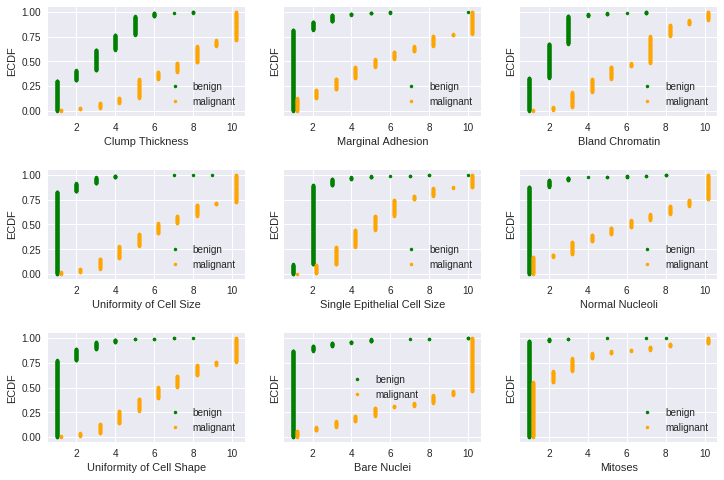

In [0]:
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(12, 8), sharey = 'all')

i = 0
j = 0
for col in data.columns[1:10]:
    pltxb = np.sort(df_class_2[col])
    pltxm = np.sort(df_class_4[col])

    pltyb = np.arange(1, len(pltxb)+1) / len(pltxb)
    pltym = np.arange(1, len(pltxm)+1) / len(pltxm)
    _ = axes[i,j].plot(pltxb, pltyb, marker = '.', linestyle='none', c = 'green', label = 'benign')
    _ = axes[i,j].plot(pltxm+.2, pltym, marker = '.', linestyle='none', c = 'orange', label = 'malignant')
    _ = axes[i,j].set_xlabel(col)
    _ = axes[i,j].set_ylabel('ECDF')
    _ = axes[i,j].legend()
    plt.subplots_adjust(hspace=.5)
    
   # _ = axes[i,j].xlabel(col)
   # _ = axes[i,j].ylabel('ECDF')
   
    if i<2:
        i += 1
    else:
        i = 0
        if j < 2:
            j+=1

###Building Predictive Model

First we split our data into test and training datasets

In [0]:
X = df_resampled.drop(['class'], axis =1)
X = X.drop(['id'], axis = 1)
Y = df_resampled.filter(['class'], axis = 1)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    X,Y, test_size = 0.3, random_state = 416)

We then construct a random forest classifier with 10k trees

In [0]:
forest = RandomForestClassifier(n_estimators = 10000, random_state = 416)
forest.fit(Xtrain, Ytrain.values.ravel())
prediction = forest.predict(Xtest)

Now we can evaluate the feature importance

In [0]:
feature_importances = pd.DataFrame(forest.feature_importances_,
                                   index = Xtrain.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances

,importance
Uniformity of Cell Size,0.268242
Bare Nuclei,0.225354
Uniformity of Cell Shape,0.168561
Bland Chromatin,0.153002
Single Epithelial Cell Size,0.060697
Normal Nucleoli,0.058672
Clump Thickness,0.031764
Marginal Adhesion,0.025850
Mitoses,0.007858


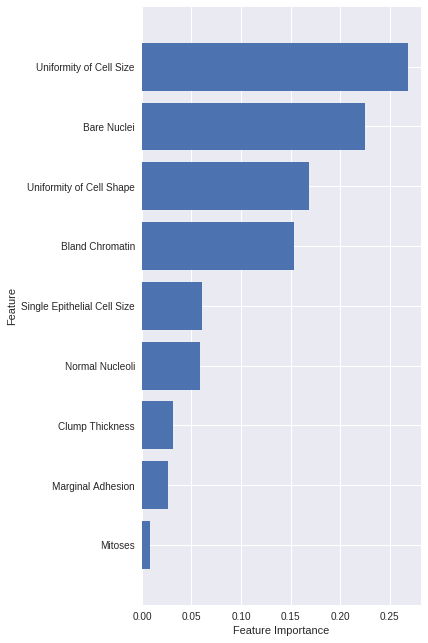

In [0]:
n_features = Xtrain.shape[1]

plt.figure(figsize=(5,11))
plt.barh(range(n_features), feature_importances['importance'], align = 'center')
plt.yticks(np.arange(n_features), list(feature_importances.index))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)
plt.gca().invert_yaxis()
plt.show()

We see that Uniformity of Cell Size, Uniformity of Cell Shape, and Bare Nuclei are more informative than the rest of the variables.

### Model fit parameters

In [0]:
forestAcc = accuracy_score(Ytest, prediction)
print("Accuracy: ",forestAcc)

Accuracy:  0.9775280898876404


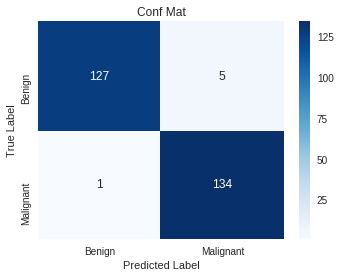

In [0]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(Ytest, np.round(prediction, 0))
cf_df = pd.DataFrame(cf, index = ["Benign", "Malignant"], columns = ["Benign", "Malignant"])

plt.figure(figsize = (5.5,4))
sns.heatmap(cf_df, cmap = "Blues",annot = True, fmt='g')
plt.title("Conf Mat")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [0]:
from sklearn.metrics import cohen_kappa_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

forestKappa = cohen_kappa_score(Ytest,prediction)
print("Cohen's Kappa: ",forestKappa)
print("F1 score: ",f1_score(Ytest, prediction, pos_label = 4))
print("Precision: ",precision_score(Ytest, prediction, pos_label = 4))
print("Recall: ",recall_score(Ytest, prediction, pos_label = 4))


Cohen's Kappa:  0.9550353654429101
F1 score:  0.9781021897810218
Precision:  0.9640287769784173
Recall:  0.9925925925925926


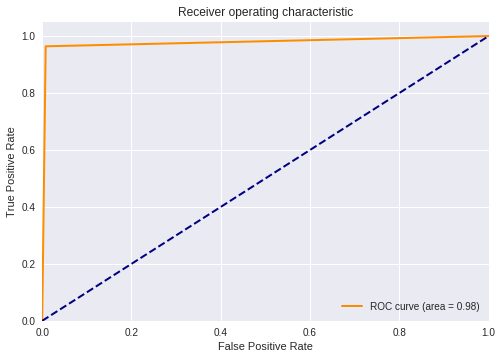

In [0]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(prediction, Ytest.values, pos_label = 4)
roc_auc = auc(fpr, tpr)
lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [0]:
Ytest.groupby("class")["class"].count()

class
2    132
4    135
Name: class, dtype: int64

##Only the top 3 features

In [0]:
Xtrain2 = Xtrain[["Bare Nuclei","Uniformity of Cell Shape","Uniformity of Cell Size"]]
Xtest2 = Xtest[["Bare Nuclei","Uniformity of Cell Shape","Uniformity of Cell Size"]]


In [0]:
forest2 = RandomForestClassifier(n_estimators = 10000, random_state = 416)
forest2.fit(Xtrain2, Ytrain.values.ravel())
prediction2 = forest2.predict(Xtest2)

In [0]:
feature_importances2 = pd.DataFrame(forest2.feature_importances_,
                                   index = Xtrain2.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances2

,importance
Bare Nuclei,0.350012
Uniformity of Cell Size,0.336617
Uniformity of Cell Shape,0.313370


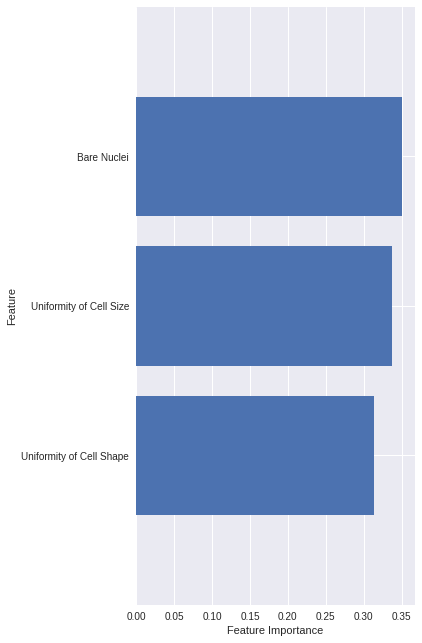

In [0]:
n_features = Xtrain2.shape[1]

plt.figure(figsize=(5,11))
plt.barh(range(n_features), feature_importances2['importance'], align = 'center')
plt.yticks(np.arange(n_features), list(feature_importances2.index))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)
plt.gca().invert_yaxis()
plt.show()

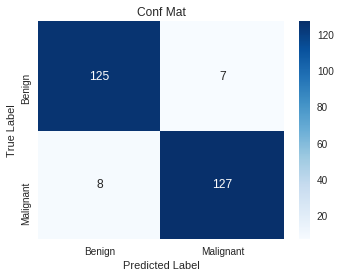

In [0]:
cf2 = confusion_matrix(Ytest, np.round(prediction2, 0))
cf_df2 = pd.DataFrame(cf2, index = ["Benign", "Malignant"], columns = ["Benign", "Malignant"])

plt.figure(figsize = (5.5,4))
sns.heatmap(cf_df2, cmap = "Blues",annot = True, fmt='g')
plt.title("Conf Mat")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [0]:
forestAcc2 = accuracy_score(Ytest, prediction2)
print("Accuracy: ",forestAcc2)

Accuracy:  0.9438202247191011


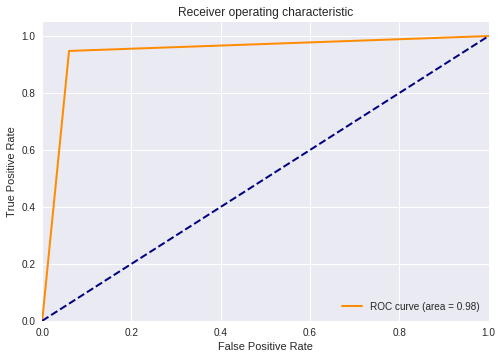

In [0]:
fpr2, tpr2, thresholds2 = roc_curve(prediction2, Ytest.values, pos_label = 4)
roc_auc2 = auc(fpr2, tpr2)
lw = 2
plt.figure()
plt.plot(fpr2, tpr2, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [0]:
temp = Ytest
temp = temp.assign(pred=prediction2)
temp = temp.assign(diff = (temp['class'] -temp['pred']))
temp = temp[temp['diff'] == 2]
temp

,class,pred,diff
273,4,2,2
273,4,2,2
455,4,2,2
103,4,2,2
222,4,2,2
603,4,2,2
288,4,2,2
15,4,2,2


In [0]:
data.loc[222,:]

id                             1226012
Clump Thickness                      4
Uniformity of Cell Size              1
Uniformity of Cell Shape             1
Marginal Adhesion                    3
Single Epithelial Cell Size          1
Bare Nuclei                          5
Bland Chromatin                      2
Normal Nucleoli                      1
Mitoses                              1
class                                4
Name: 222, dtype: int64